# Phase II: Data Curation, Exploratory Analysis and Plotting
## Stock Market Predictor

### Names: Diego Cicotoste, Ariv Ahuja, Salma Elmosallamy, Rithik Raghuraman

# Introduction 

How does the stock market work? how can you predict the stock market? what tools can you use? The stock market can seem complex and unpredictable, some would even say gambeling. One of the hardest challenges is making educated or informed decisions. The goal of this project is to tackle the uncertainty and help, stock traders make better decision on wether a stock is tradable or not. Wether to buy or sell. I would use past historical trends to make educated predictions on how the stock market would react.

### **1. Data Retrieval**  
- We used the **`yfinance` API** to retrieve daily historical **Open, High, Low, Close (OHLC)** prices and **volume data** for **S&P 500 stocks**, focusing on **Amazon (AMZN)** for the **past year**.
- The retrieved data includes essential market metrics that will serve as the foundation for feature engineering.

---

### **2. Data Cleaning and Processing**

#### **Handling Missing Data**  
- No data was missing after inspection

#### **Feature Engineering: Technical Indicators**  
We calculated several key **technical indicators** to enrich the dataset:
  - **RSI (Relative Strength Index)**: Momentum indicator over 14 days.
  - **VWAP (Volume Weighted Average Price)**: Measures the average trading price weighted by volume.
  - **EMA (Exponential Moving Average)**: Captures the smoothed trend over 20 days.
  - **ADX (Average Directional Index)**: Quantifies trend strength.

#### **More Features: Sentiment Analysis from News Articles**  
- We fetched relevant **news articles** using **NewsAPI** for the same period as the stock data.
- **VADER Sentiment Analysis** was used to calculate **compound sentiment scores** for each article.
- Sentiment scores were **aggregated by date** to align with the stock OHLC data.

#### **Data Alignment and Merging**  
- We ensured **alignment** between **OHLC data, technical indicators, log returns, and sentiment scores** using date-based indices.
- The combined DataFrame was prepared, with all relevant features available for further analysis and modeling.

---

### **3. Visualization of the Cleaned Data**

We visualized the **cleaned and processed dataset** to understand key trends and patterns:

1. **Price Trends and Indicators**:
   - **OHLC Candlestick Plots**: Show stock price movements.
   - **Overlaying VWAP and EMA**: To track trends and identify support/resistance levels.
   - **RSI and ADX Line Plots**: Visualize momentum and trend strength over time.

2. **Volume Analysis**:
   - **Normalized Volume**: Visualized to detect significant changes in trading activity.

3. **Sentiment Trends**:
   - **Sentiment Score Line Chart**: Displays how public sentiment fluctuates over time.
   - **Overlay of Sentiment with Stock Price**: To observe correlations between sentiment and price movements.


In [6]:
import yfinance as yf
import pandas as pd

def get_stock_data(symbol: str, period: str, interval: str = '1d') -> pd.DataFrame:
    """
    Retrieve stock price data for a given symbol, time period, and interval.
    Returns the stock prices as a pandas DataFrame.

    Parameters:
        symbol (str): The ticker symbol of the stock (e.g., 'AAPL').
        period (str): The period to retrieve data (e.g., '1y', '6mo', '5d').
        interval (str): The data interval (e.g., '1d', '1wk', '1mo').

    Returns:
        pd.DataFrame: DataFrame containing historical stock prices.
    """
    # Fetch data from Yahoo Finance
    stock_data = yf.download(symbol, period=period, interval=interval)

    return stock_data

In [7]:
import numpy as np

def calculate_log_returns(close: np.ndarray) -> np.ndarray:
    """
    Calculate the log returns from the close prices.
    
    Parameters:
        close (np.ndarray): Array of closing prices.
    
    Returns:
        np.ndarray: Array of log returns.
    """
    log_returns = np.log(close / close.shift(1))
    
    return log_returns


In [8]:
import pandas_ta as ta

def calculate_technical_indicators(df: pd.DataFrame) -> dict:
    """
    Calculate technical indicators and return them as NumPy arrays.

    Parameters:
        df (pd.DataFrame): DataFrame containing historical stock prices.

    Returns:
        dict: A dictionary with technical indicators as NumPy arrays.
    """
    indicators = {}

    # Calculate RSI (Relative Strength Index)
    indicators['rsi'] = ta.rsi(df['Close'], length=20).to_numpy()

    # Calculate 20-day Exponential Moving Average (EMA)
    indicators['ema'] = ta.ema(df['Close'], length=20).to_numpy()

    # Calculate ADX (Average Directional Index)
    adx_df = ta.adx(df['High'], df['Low'], df['Close'], length=20)
    indicators['adx'] = adx_df['ADX_20'].to_numpy()

    # Calculate VWAP (Volume Weighted Average Price)
    vwap_series = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
    indicators['vwap'] = vwap_series.to_numpy()

    # Calculate normalized volume
    indicators['normalized_volume'] = (df['Volume'] / df['Volume'].rolling(window=20).mean()).to_numpy()

    return indicators

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import random
import time
from urllib.parse import quote
import undetected_chromedriver as uc

def get_seekingalpha_articles(ticker: str, start_date: datetime, end_date: datetime):
    """
    Scrapes article titles and publication dates for a given stock ticker 
    from Seeking Alpha within the specified date range.

    Parameters:
        ticker (str): Stock ticker symbol (e.g., 'AMZN').
        start_date (datetime): Start date as a datetime object.
        end_date (datetime): End date as a datetime object.

    Returns:
        pd.Series: Series of article titles.
        pd.Series: Series of article dates.
    """
    start_str = start_date.strftime('%Y-%m-%dT%H:%M:%S.000Z')
    end_str = end_date.strftime('%Y-%m-%dT%H:%M:%S.999Z')

    # URL-encode the formatted strings
    start_str = quote(start_str, safe='')
    end_str = quote(end_str, safe='')

    page_num = 1
    all_titles, all_dates = [], []


    # Set up Chrome options for headless mode
    options = uc.ChromeOptions()
    options.add_argument('--headless')
    
    # Initialize undetected-chromedriver with the configured options
    driver = uc.Chrome()

    while True:
        url = f"https://seekingalpha.com/symbol/{ticker}/news?from={start_str}&page={page_num}&to={end_str}"

        time.sleep(random.uniform(1, 3))
        driver.get(url)
    
        # Allow some time for the page to load
        time.sleep(3)

        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        # Extract titles and dates
        titles = soup.find_all('a', {'data-test-id': 'post-list-item-title'})
        dates = soup.find_all('span', {'data-test-id': 'post-list-date'})

        if not titles or not dates:
            break  # Stop if no more articles are found

        for title, date in zip(titles, dates):
            title_text = title.text.strip()
            date_str = date.text.strip()

            # Handle if it is recent
            if date_str.lower().startswith('yest'):
                parsed_date = datetime.now() - timedelta(days=1)
            elif date_str.lower().startswith('toda'):
                parsed_date = datetime.now()
                
            # Handle date strings with or without a year
            elif date_str[-4:].isdigit():  # If the string contains a year
                date_format = '%a, %b %d, %Y' if "May" in date_str else '%a, %b. %d, %Y'
                parsed_date = datetime.strptime(date_str, date_format)
            else:
                date_str = f'{date_str}, {datetime.now().year}'
                date_format = '%a, %b %d, %Y' if "May" in date_str else '%a, %b. %d, %Y'
                parsed_date = datetime.strptime(date_str, date_format)

            # Append to the result lists
            all_titles.append(title_text)
            all_dates.append(parsed_date)
        
        page_num += 1

    return all_titles, all_dates

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import numpy as np
import pandas as pd

# Load the FinBERT model and tokenizer from Hugging Face
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert', num_labels=3)
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

# Set up the pipeline for sentiment analysis
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None, device=0)

def analyze_sentiment(titles: list) -> np.ndarray:
    """
    Analyzes sentiment of article titles using FinBERT and returns cumulative sentiment scores.

    Parameters:
        titles (list): List of article titles.

    Returns:
        np.ndarray: Array of cumulative sentiment scores.
    """
    cumulative_scores = []

    for title in titles:
        result = nlp(title)[0]  # Get sentiment scores for the title

        # Extract individual scores
        scores = {entry['label'].lower(): entry['score'] for entry in result}
        positive = scores.get('positive', 0)
        negative = scores.get('negative', 0)

        # Calculate cumulative sentiment
        cumulative_score = positive - negative

        # Append to cumulative scores list
        cumulative_scores.append(cumulative_score)

    return np.array(cumulative_scores)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from datetime import datetime
import numpy as np

def merge_sentiment(
    date_list: list, 
    sent_arr: np.ndarray, 
    index_dates: np.ndarray
) -> np.ndarray:
    """
    Merges sentiment scores by date, averaging multiple scores per day. 
    If a date has no articles, it fills the sentiment with 0.

    Parameters:
        date_list (list): List of datetime objects representing article publication dates.
        sent_arr (np.ndarray): Array of sentiment scores corresponding to the article dates.
        index_dates (np.ndarray): Array of indexed dates from the DataFrame.

    Returns:
        np.ndarray: Array of average daily sentiment scores aligned with the index dates.
    """
    # Initialize an array for daily sentiment scores aligned with the index dates
    daily_sentiment = np.zeros(len(index_dates))

    

    # Create a dictionary to group sentiment scores by date
    sentiment_by_date = {}
    for date, score in zip(date_list, sent_arr):
        if date not in sentiment_by_date:
            sentiment_by_date[date] = []
        sentiment_by_date[date].append(score)
        
    # Iterate over the dates and compute the average sentiment for each
    for idx, current_date in enumerate(index_dates):
        if current_date in sentiment_by_date:
            # Calculate the average sentiment for the current date
            daily_sentiment[idx] = np.mean(sentiment_by_date[current_date])


    return daily_sentiment


In [ ]:
# Example usage
stock = 'AMZN'
period = '2y'
interval = '1d'

# Fetch stock data
stock_ohlc = get_stock_data(stock, period, interval)

# Calculate log returns
log_returns_arr = calculate_log_returns(stock_ohlc['Close'])

# Calculate technical indicators (RSI, EMA, VWAP, etc.)
technical_indicators_dict = calculate_technical_indicators(stock_ohlc)

# Add calculated fields to stock dataframe
stock_df = stock_ohlc
stock_df['log_returns'] = log_returns_arr
stock_df['rsi'] = technical_indicators_dict['rsi']
stock_df['ema'] = technical_indicators_dict['ema']
stock_df['vwap'] = technical_indicators_dict['vwap']
stock_df['adx'] = technical_indicators_dict['adx']
stock_df['normalized_volume'] = technical_indicators_dict['normalized_volume']

# Convert date to string for the article collection
first_date = stock_ohlc.index.min()
last_date = stock_ohlc.index.max()

# Get latest news articles and add sentiment scores
article_titles, dates  = get_seekingalpha_articles(stock, first_date, last_date)
sentiment_arr = analyze_sentiment(article_titles)
sentiment_aligned = merge_sentiment(dates, sentiment_arr, stock_ohlc.index.to_pydatetime())

# Add the sentiment array to the stock DataFrame
stock_df['sentiment_score'] = sentiment_aligned

# Drop Nan values from DF
stock_df = stock_df.dropna()

# Display the final dataframe
stock_df

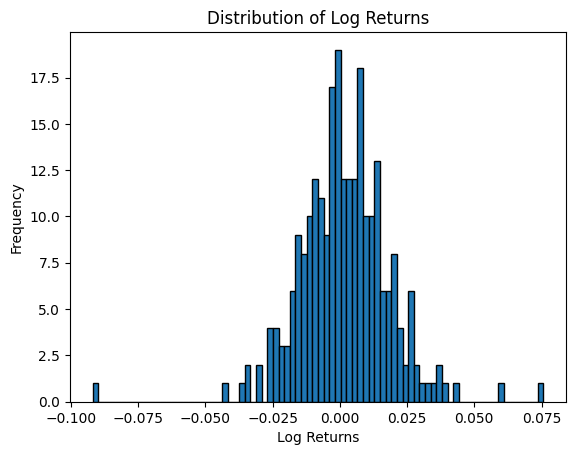

In [48]:
import matplotlib.pyplot as plt

# Plot histogram of log returns
plt.hist(log_returns_arr, bins=80, edgecolor='black')
plt.title('Distribution of Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.show()

The bimodal distribution observed in the log returns suggests volatility clustering, where the market exhibits frequent up or down movements, with fewer instances of no change. This non-linear behavior makes it challenging to use such features effectively in linear regression, as the model assumes a linear relationship between variables. The two peaks around zero highlight the market’s preference to shift rather than remain flat, reflecting non-stationary behavior. Also the data is shifted to the right slightly because stocks in general return positive returns over long time frames.

In [14]:
# Correlations
df_corr = stock_df[["log_returns", "Volume", "rsi", "ema", "vwap", "adx", "sentiment_score"]]
correlations = df_corr.corr()
correlations

,log_returns,Volume,rsi,ema,vwap,adx,sentiment_score
log_returns,1.000000,0.099324,0.322576,-0.045118,0.003346,-0.023305,0.034640
Volume,0.099324,1.000000,0.093908,-0.481461,-0.469707,0.061637,-0.086070
rsi,0.322576,0.093908,1.000000,-0.097912,0.031542,0.332254,-0.011347
ema,-0.045118,-0.481461,-0.097912,1.000000,0.989844,-0.009224,0.142059
vwap,0.003346,-0.469707,0.031542,0.989844,1.000000,0.009724,0.146812
adx,-0.023305,0.061637,0.332254,-0.009224,0.009724,1.000000,-0.052745
sentiment_score,0.034640,-0.086070,-0.011347,0.142059,0.146812,-0.052745,1.000000


This table provides the correlations between closeing price for the day, volume of shares trades, technical indicators (like rsi, ema, vwap, adx), and sentiment score for each day the Amazon stock is traded. Based on these correlations, we can determine which variables have the strongest relationships, which gives us a better understanding of the data when analyzing. 

**Notable Relationships:**
1. **Close and EMA (exponential moving average):** The high correlation of 0.904341 suggests that EMA can be a valuable indicator in predicting the closing price of Amazon's stock. This relationship makes sense the EMA is calulated using data from historical prices. This allows investors to confidently use the EMA as part of strategies to predict price movements, identify trends, and make informed decisions on entry and exit points for their trades.  
2. **EMA and VWAP (volume weighted average price):** This relationship has a strong positive correlation of 0.907945. EMA tracks trends purely based on price, while vwap also takes volume of shares into consideration. This strong relationship suggests that price movements are well supported by trading volumes. This signals to investors good times to buy/sell a stock.    
3. **VWAP and ADX (average directional index):** There is a moderate inverse relationship between these two factors, suggested by a correlation of -0.464629. ADX is used to measure the strength of a trend. As the VWAP increases, the ADX tends to decrease, which makes sense because with a higher trading volume comes greater uncertainty and prices may be more scattered.

The correlation between technichal indicators and sentiment scores were also an area of interest for our group, however there does not appaer to be a strong relationship between any. Therefore, this tells us that the sentiment of recent news articles many not have a significant impact on stock trends. 

In [50]:
import plotly.graph_objects as go

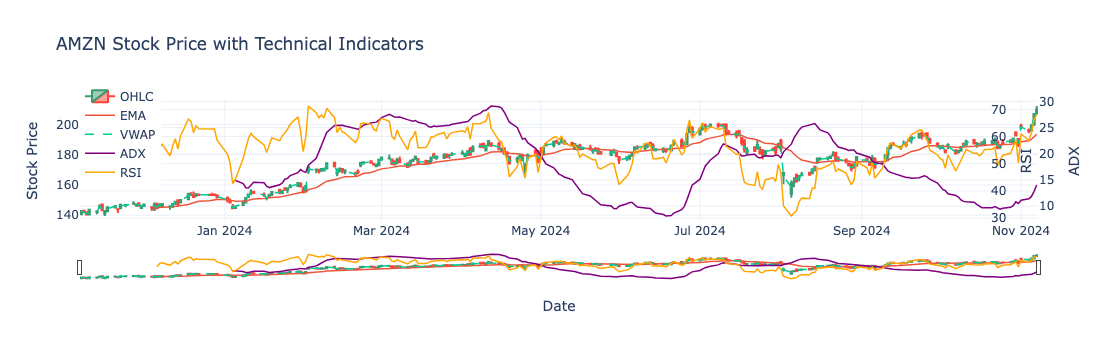

In [51]:
# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=stock_df.index,
    open=stock_df['Open'],
    high=stock_df['High'],
    low=stock_df['Low'],
    close=stock_df['Close'],
    name='OHLC'
)])

# Add the EMA line
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['ema'],
    mode='lines',
    line=dict(width=1.5),
    name='EMA'
))

# Add VWAP line
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['vwap'],
    mode='lines',
    line=dict(width=1.5, dash='dash'),
    name='VWAP'
))

# Add ADX line on the secondary y-axis
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['adx'],
    mode='lines',
    line=dict(width=1.5, color='purple'),
    name='ADX',
    yaxis="y2"
))

# Add RSI line on a secondary y-axis
fig.add_trace(go.Scatter(
    x=stock_df.index,
    y=stock_df['rsi'],
    mode='lines',
    line=dict(width=1.5, color='orange'),
    name='RSI',
    yaxis="y3"
))

# Update layout for readability and add secondary y-axes
fig.update_layout(
    title=f'{stock} Stock Price with Technical Indicators',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    yaxis2=dict(
        title="ADX",
        overlaying="y",
        side="right"
    ),
    yaxis3=dict(
        title="RSI",
        anchor="free",
        overlaying="y",
        side="right",
        position=0.95  
    ),
    legend=dict(x=0, y=1.15),
    template="plotly_white"
)

fig.show()

This candlestick plot shows the trend of Amazon's stock price from December 2023 all the way to the most recent date Amazon's stock was traded. The hover feature shows the date, open, close, high, and low prices of a particular day, as well as it shows the indicators we have included to help predict the graph. Additionally, based on the green and red color scheme, we can see when Amazon's stock price increased/decreased as well as the range it was traded at for the day. 

# Phase III

In [3]:
stock_df = pd.read_csv('amzn_2y.csv')

In [5]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,log_returns,rsi,ema,vwap,adx,normalized_volume,sentiment_score
0,2023-01-11,90.930000,95.260002,90.930000,95.089996,95.089996,103126200,0.056460,58.857347,87.772519,93.760000,16.446174,1.353937,-0.090275
1,2023-01-12,96.930000,97.190002,93.500000,95.269997,95.269997,85254800,0.001891,59.092719,88.486565,95.320000,16.918704,1.130404,0.113091
2,2023-01-13,94.180000,98.370003,94.120003,98.120003,98.120003,85549400,0.029476,62.653618,89.404035,96.870003,17.586948,1.122956,0.087903
3,2023-01-17,98.680000,98.889999,95.730003,96.050003,96.050003,72755000,-0.021322,58.744092,90.036984,96.890002,18.294529,0.962623,-0.019294
4,2023-01-18,97.250000,99.320000,95.379997,95.459999,95.459999,79570400,-0.006162,57.664529,90.553462,96.719999,19.021528,1.101301,-0.118302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,2024-11-06,200.009995,207.550003,199.139999,207.089996,207.089996,72292200,0.037339,66.376340,191.900874,204.593333,12.820632,1.930385,0.491510
459,2024-11-07,207.440002,212.250000,207.190002,210.050003,210.050003,52878400,0.014192,68.067186,193.629362,209.830002,14.019819,1.366215,0.735861
460,2024-11-08,209.720001,209.960007,207.440002,208.179993,208.179993,36075800,-0.008943,65.864570,195.015136,208.526667,15.159047,0.919820,0.625888
461,2024-11-11,208.500000,209.649994,205.589996,206.839996,206.839996,35405100,-0.006458,64.295235,196.141314,207.359996,16.010175,0.888235,0.000000


In [21]:
from sklearn.preprocessing import StandardScaler

# Set up the features (X) and target (y)
X = stock_df[['rsi', 'ema', 'vwap', 'adx', 'normalized_volume', 'sentiment_score']]
y = stock_df[['log_returns']]

# Get the number of samples
n = stock_df.shape[0]

# Calculate the indices for the splits
train_end = int(0.65 * n)  # 65% for training
cv_end = int(0.80 * n)     # Next 15% for CV (up to 80%)

# Split the data
X_train = X[:train_end]
X_cv = X[train_end:cv_end]
X_test = X[cv_end:]

y_train = y[:train_end]
y_cv = y[train_end:cv_end]
y_test = y[cv_end:]

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cv)
X_test_scaled = scaler.transform(X_test)